In [1]:
!pip install cmfrec

     |████████████████████████████████| 242 kB 37.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached findblas-0.1.19-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.2.2.post3-cp37-cp37m-linux_x86_64.whl size=4276609 sha256=5392f030c17cb57ec2243866e43a330ab7993bad9f4e78475498132edb585f63
  Stored in directory: /root/.cache/pip/wheels/df/91/25/16fddd48bd59883488b3cfae2cee4b2450c94c6dbaea788cc6
Successfully built cmfrec


In [2]:
!pip install threadpoolctl

In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 30.4 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "gdrive/MyDrive/Datasets"

Mounted at /content/gdrive
ratings_small.csv		  user_topologycal_properties4.csv
user_topologycal_properties1.csv  user_topologycal_properties5.csv
user_topologycal_properties2.csv  user_topologycal_properties6.csv
user_topologycal_properties3.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from cmfrec import CMF
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import statistics
import shap

In [6]:
df_ratings = pd.read_csv('gdrive/MyDrive/Datasets/ratings_small.csv', usecols=[0, 1, 2])
print("Number of ratings: {0}".format(df_ratings.shape[0]))
user_count = df_ratings['UserId'].nunique()
movie_count = df_ratings["ItemId"].nunique()
print("Number of users: {0}".format(user_count))
print("Number of movies: {0}".format(movie_count))

Number of ratings: 100004
Number of users: 671
Number of movies: 9066


In [7]:
df_ratings.describe()

,UserId,ItemId,Rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,3.543608
std,195.163838,26369.198969,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,1028.000000,3.000000
50%,367.000000,2406.500000,4.000000
75%,520.000000,5418.000000,4.000000
max,671.000000,163949.000000,5.000000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


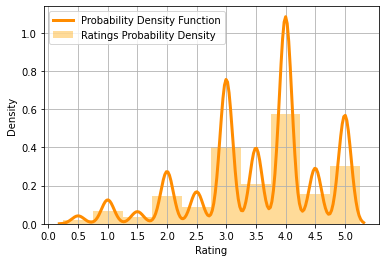

In [13]:
ratings_list = df_ratings['Rating'].tolist()
d = 1/2
left_of_first_bin = min(ratings_list) - d/2
right_of_last_bin = max(ratings_list) + d/2
b = np.arange(left_of_first_bin, right_of_last_bin + d, d)
plt.clf()
sns.distplot(ratings_list, bins=b, hist=True, kde=True, color='darkorange', kde_kws={'linewidth': 3}, hist_kws={'color':'orange'})
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.legend(labels=['Probability Density Function','Ratings Probability Density'])
plt.grid()
plt.show()

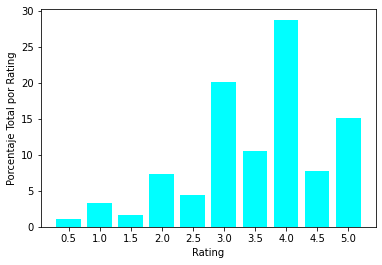

In [12]:
p = df_ratings.groupby('Rating')['Rating'].agg(['count'])
ratings = []
for i in np.arange(0.5, 5.5, 0.5):
    ratings.append(str(i))
rating_percentage = []
for i in range(len(p)):
    rating_percentage.append(p.iloc[i][0]*100 / p.sum()[0])

plt.clf()
plt.bar(ratings, rating_percentage, color="cyan")
plt.xlabel('Rating')
plt.ylabel('Porcentaje Total por Rating')
plt.show()

In [10]:
#Grid Search
rmse_min = np.inf
ans = None
k_values = [10, 20, 30, 50, 100] #latent factors
lamda_values = [0.1, 1, 10, 50] #regularization parameter

for k_ in k_values:
  for l_ in lamda_values:
    #Train-Test Split Dataset
    users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
    items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
    ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
    users_train = ratings_train.UserId.unique()
    items_train = ratings_train.ItemId.unique()
    ratings_test = ratings_test.loc[ratings_test.UserId.isin(users_train) & ratings_test.ItemId.isin(items_train)]

    #Fit Model
    model = CMF(method="als", k=k_, lambda_=l_, verbose=False).fit(ratings_train)

    #Predictions
    predictions = model.predict(ratings_test.UserId, ratings_test.ItemId)

    #RMSE
    rmse = metrics.mean_squared_error(ratings_test.Rating, predictions, squared=True)

    if rmse < rmse_min:
      rmse_min = rmse
      ans = [k_, l_]

print("The best RMSE is {0} and is obtained with the parameters k={1} and lambda={2}".format(rmse_min, ans[0], ans[1]))

The best RMSE is 0.7579181928964689 and is obtained with the parameters k=100 and lambda=10


# Recommendation without topological properties

In [11]:
HOLDOUT = 20
h_rmse = []
h_mae = []
h_r2 = []

for i in range(HOLDOUT):
  #Train-Test Split Dataset
  users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
  ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
  users_train = ratings_train.UserId.unique()
  items_train = ratings_train.ItemId.unique()
  ratings_test = ratings_test.loc[ratings_test.UserId.isin(users_train) & ratings_test.ItemId.isin(items_train)]

  #Fit Model
  model = CMF(method="als", k=100, lambda_=10, verbose=False).fit(ratings_train)

  #Predictions
  predictions = model.predict(ratings_test.UserId, ratings_test.ItemId)

  #Metrics
  rmse = metrics.mean_squared_error(ratings_test.Rating, predictions, squared=True)
  mae = metrics.mean_absolute_error(ratings_test.Rating, predictions)
  r2 = metrics.r2_score(ratings_test.Rating, predictions)
  h_rmse.append(rmse)
  h_mae.append(mae)
  h_r2.append(r2)

#Algorithm analysis
mean_h_rmse = statistics.mean(h_rmse)
mean_h_mae = statistics.mean(h_mae)
mean_h_r2 = statistics.mean(h_r2)
stdev_h_rmse = statistics.stdev(h_rmse)
stdev_h_mae = statistics.stdev(h_mae)
stdev_h_r2 = statistics.stdev(h_r2)
print("Holdout Report")
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))

Holdout Report
Mean of RMSE, MAE, R2: 0.7692309538089119, 0.6763922772504917, 0.3040961971938868
Standard deviation of RMSE, MAE, R2: 0.016119241088169443, 0.006870246545009148, 0.013511236135440112


# Recommendation using topological properties (CMF)


In [14]:
for i in range(6):

  filename = "gdrive/MyDrive/Datasets/user_topologycal_properties{0}.csv".format(i+1)
  df_users = pd.read_csv(filename)
  #Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  
  HOLDOUT = 20
  for j in range(HOLDOUT):
    #Train-Test Split Dataset
    users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
    items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
    ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
    users_train = ratings_train.UserId.unique()
    items_train = ratings_train.ItemId.unique()
    ratings_test = ratings_test.loc[ratings_test.UserId.isin(users_train) & ratings_test.ItemId.isin(items_train)]
    user_attr_train = df_users.loc[df_users.UserId.isin(users_train)]

    #Fit Model
    m_collective = CMF(method="als", k=100, lambda_=10, verbose=False).fit(X=ratings_train, U=user_attr_train)

    #Predictions
    predictions = m_collective.predict(ratings_test.UserId, ratings_test.ItemId)

    #Metrics
    rmse = metrics.mean_squared_error(ratings_test.Rating,predictions,squared=True)
    mae = metrics.mean_absolute_error(ratings_test.Rating,predictions)
    r2 = metrics.r2_score(ratings_test.Rating,predictions)
    h_rmse.append(rmse)
    h_mae.append(mae)
    h_r2.append(r2)

  #Algorithm analysis
  mean_h_rmse = statistics.mean(h_rmse)
  mean_h_mae = statistics.mean(h_mae)
  mean_h_r2 = statistics.mean(h_r2)
  stdev_h_rmse = statistics.stdev(h_rmse)
  stdev_h_mae = statistics.stdev(h_mae)
  stdev_h_r2 = statistics.stdev(h_r2)
  print("Holdout Report for Model {0}".format(i+1))
  print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
  print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))
  print()

Holdout Report for Model 1
Mean of RMSE, MAE, R2: 0.7692358800541844, 0.6763817605154723, 0.30492660215225476
Standard deviation of RMSE, MAE, R2: 0.01750711154227068, 0.007906741798369251, 0.013828648659059624

Holdout Report for Model 2
Mean of RMSE, MAE, R2: 0.7691975363478387, 0.6765074901157759, 0.30660296266659
Standard deviation of RMSE, MAE, R2: 0.016581515195477497, 0.00755990959808961, 0.013785669627080523

Holdout Report for Model 3
Mean of RMSE, MAE, R2: 0.7688032171263617, 0.6761780360585277, 0.30698556985490594
Standard deviation of RMSE, MAE, R2: 0.015937662385070446, 0.007599543477549757, 0.012755838092306276

Holdout Report for Model 4
Mean of RMSE, MAE, R2: 0.7671319535464233, 0.6754384389709441, 0.30750155223725345
Standard deviation of RMSE, MAE, R2: 0.01656587534339736, 0.007578125723036415, 0.012662939494425294

Holdout Report for Model 5
Mean of RMSE, MAE, R2: 0.7667004977651634, 0.6753089120366997, 0.30774922551041145
Standard deviation of RMSE, MAE, R2: 0.01636

Hay mejoras en todos los modelos con respecto a la recomendación sin el uso de medidas topológicas del grafo. El cambio más notorio es en el modelo 6 con una mejora en el RMSE de 0.002644